Project 3 - Part B: Non-Logistic Models 

Cleaning and Pre-Processing 

In [1]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import RocCurveDisplay

In [2]:
#download cleaned data set 
df = pd.read_csv('cleaned_new_train_EGN5442.csv')
print(df.head())
print(df.info())
print(df.describe())
print(df.isna().sum())

   Unnamed: 0  y  x5  x9  x10  x11  x12  x13  x15  x16  ...  x29_(991&&)  \
0           0  1  50   5    5    5    4    3    3    3  ...        False   
1           1  1  44   1    1    1    1    3    1    4  ...        False   
2           2  0  72   3    1    5    5    3    2    3  ...        False   
3           3  0  38   1    3    1    3    5    5    5  ...        False   
4           4  1  37   5    5    5    5    2    5    4  ...        False   

   x29_(992&&)  x29_(993&&)  x29_(994&&)  x29_(995&&)  x29_(996&&)  \
0        False        False        False        False        False   
1        False        False        False        False        False   
2        False        False        False        False        False   
3        False        False        False        False        False   
4        False        False        False        False        False   

   x29_(997&&)  x29_(998&&)  x29_(999&&)  x5_binned  
0        False        False        False          2  
1        False

C:\Users\jialj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
C:\Users\jialj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\lib\_function_base_impl.py:4671: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


In [3]:
df = df.drop(columns=['x31'], errors='ignore')
df.isna().sum().sum()

np.int64(0)

Train / Validation / Test

In [4]:
y = df['y']              

# X = all other columns
X = df.drop(columns=['y'])
print("X shape:", X.shape)
print("y shape:", y.shape)

#first split 60/40 train/temp
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.40, random_state=0, stratify=y
)

#second split 20/20 validation/test
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=0, stratify=y_temp
)

print("Train:", X_train.shape, y_train.shape)
print("Val  :", X_val.shape,  y_val.shape)
print("Test :", X_test.shape, y_test.shape)

X shape: (94, 107732)
y shape: (94,)
Train: (56, 107732) (56,)
Val  : (19, 107732) (19,)
Test : (19, 107732) (19,)


Build Random Forest Model 

In [5]:
param_dist = {
    'n_estimators': [200, 400, 600, 800],
    'max_depth': [10, 20, 40, 60, None],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 8],
    'max_features': ['sqrt', 'log2', None]
}

rf = RandomForestClassifier(random_state=0)

rf_search = RandomizedSearchCV(
    rf,
    param_distributions=param_dist,
    n_iter=25,
    scoring='roc_auc',
    cv=5,
    n_jobs=-1,
    verbose=1,
    random_state=0
)

rf_search.fit(X_train, y_train)
print("Best RF Params:", rf_search.best_params_)

best_rf = rf_search.best_estimator_


Fitting 5 folds for each of 25 candidates, totalling 125 fits
Best RF Params: {'n_estimators': 600, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': None, 'max_depth': 20}


In [6]:
train_proba = best_rf.predict_proba(X_train)[:, 1]
train_auc = metrics.roc_auc_score(y_train, train_proba)
print("Training AUC:", train_auc)

val_proba = best_rf.predict_proba(X_val)[:, 1]
val_auc = metrics.roc_auc_score(y_val, val_proba)
print("Validation AUC:", val_auc)

# Test
test_proba = best_rf.predict_proba(X_test)[:, 1]
test_auc = metrics.roc_auc_score(y_test, test_proba)
print("Test AUC:", test_auc)

Training AUC: 0.9974193548387097
Validation AUC: 0.9545454545454545
Test AUC: 0.8888888888888888


Accuracy : 0.7368421052631579
Precision: 0.75
Recall   : 0.6666666666666666
F1 Score : 0.7058823529411765


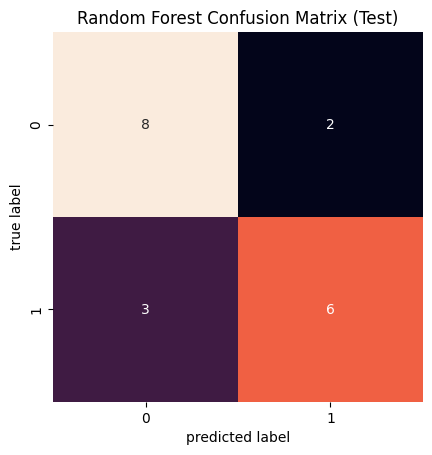

In [7]:
y_test_pred = best_rf.predict(X_test)

print("Accuracy :", metrics.accuracy_score(y_test, y_test_pred))
print("Precision:", metrics.precision_score(y_test, y_test_pred))
print("Recall   :", metrics.recall_score(y_test, y_test_pred))
print("F1 Score :", metrics.f1_score(y_test, y_test_pred))

# cm = confusion_matrix(y_test, y_test_pred)
# ConfusionMatrixDisplay(cm).plot()
# plt.title("Random Forest Confusion Matrix (Test)")
# plt.show()

cm = metrics.confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('predicted label')
plt.ylabel('true label')
plt.title("Random Forest Confusion Matrix (Test)")
plt.show()


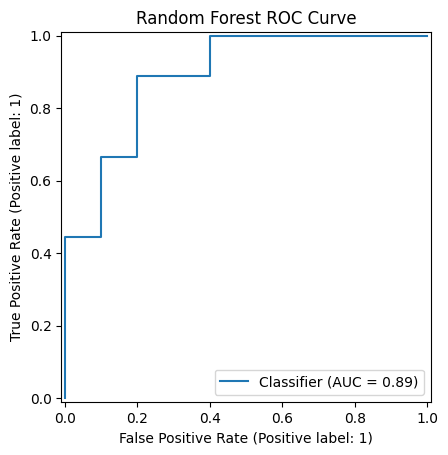

In [9]:
RocCurveDisplay.from_predictions(y_test, test_proba)
plt.title("Random Forest ROC Curve")
plt.show()

Exploring Overfitting 

In [ ]:
rf_overfit = RandomForestClassifier(
    n_estimators=500,
    max_depth=None,           
    min_samples_split=2,
    min_samples_leaf=1,
    max_features=None,
    random_state=0
)

rf_overfit.fit(X_train, y_train)

#train AUC
train_proba = rf_overfit.predict_proba(X_train)[:, 1]
train_auc = metrics.roc_auc_score(y_train, train_proba)

#test AUC 
test_proba = rf_overfit.predict_proba(X_test)[:, 1]
test_auc = metrics.roc_auc_score(y_test, test_proba)

print("Overfit Model – Train AUC:", train_auc)
print("Overfit Model – Test AUC :", test_auc)

Overfit Model – Train AUC: 1.0
Overfit Model – Test AUC : 0.8888888888888888


In [11]:
rf_fixed = RandomForestClassifier(
    n_estimators=300,
    max_depth=10,             
    min_samples_split=10,     
    min_samples_leaf=4,       
    max_features='sqrt',     
    random_state=0
)

rf_fixed.fit(X_train, y_train)

train_proba_fixed = rf_fixed.predict_proba(X_train)[:, 1]
test_proba_fixed  = rf_fixed.predict_proba(X_test)[:, 1]

train_auc_fixed = metrics.roc_auc_score(y_train, train_proba_fixed)
test_auc_fixed  = metrics.roc_auc_score(y_test, test_proba_fixed)

print("Regularized Model – Train AUC:", train_auc_fixed)
print("Regularized Model – Test AUC :", test_auc_fixed)

Regularized Model – Train AUC: 0.9896774193548387
Regularized Model – Test AUC : 0.8999999999999999
